[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab10_diffusion.ipynb)

# Denoising Diffusion Probabilistic Models (DDPM)

## Description

In this lab, we train an image generation model using diffusion. Diffusion is just one of several techniques to generate images, but it has recently surpassed the GAN as the state-of-the-art generation model.

The diffusion model is trained to remove noise from images, and once it is fully trained it can take random noise and fully "denoise" it into an image that looks reasonably like the training set.

## Objectives
- Implement forward process of diffusion
- Implement backward process of diffusion
- Generate images with the diffusion process
- Answer questions about diffusion

## Grading Criteria
- Scheduling (10%)
- Forward Diffusion (30%)
- Backward Diffusion (30%)
- Image Generation (20%)
- Answers to Questions (10%)

### Helpful Reading
- Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
- Improved Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2102.09672



In [1]:
from abc import abstractmethod
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, Resize, Lambda, ToTensor

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.mps.is_available() else torch.device("cpu")

In [2]:
# Hyperparameters
MAX_TIMESTEPS = 1000
IMAGE_SIZE = 32
LR = .0001

We have given you a simpler version of the UNet used in "Improved Denoising Diffusion Probabilistic Models." Feel free to familiarize yourself with the model. It is similar to the UNet we made in the cancer detection lab, but has layers that incorporate the timestep embedding. The model is already fully implemented.

In [3]:
def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module


def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


# Note: this is an abstract method, do not implement `forward`
class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels

        self.in_layers = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, self.out_channels, 3, padding=1)
        )
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_channels, self.out_channels)
        )
        self.out_layers = nn.Sequential(
            nn.GroupNorm(32, self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        h = h + emb_out
        h = self.out_layers(h)
        return self.skip_connection(x) + h


class UNetModel(nn.Module):
    """
    The full UNet model with timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    """

    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_res_blocks,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
    ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = hidden_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        self.channel_mult = channel_mult

        time_embed_dim = hidden_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(hidden_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, hidden_channels, 3, padding=1))
        ])
        input_block_chans = [hidden_channels]
        ch = hidden_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * hidden_channels)]
                ch = mult * hidden_channels
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch)))
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout),
            ResBlock(ch, time_embed_dim, dropout),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResBlock(
                        ch + input_block_chans.pop(),
                        time_embed_dim,
                        dropout,
                        out_channels=hidden_channels * mult,
                    )
                ]
                ch = hidden_channels * mult
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            nn.GroupNorm(32, ch),
            nn.SiLU(),
            zero_module(nn.Conv2d(hidden_channels, out_channels, 3, padding=1))
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.

        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x H x W] Tensor of outputs.
        """

        xs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        for module in self.input_blocks:
            x = module(x, emb)
            xs.append(x)
        x = self.middle_block(x, emb)
        for module in self.output_blocks:
            cat_in = torch.cat([x, xs.pop()], dim=1)
            x = module(cat_in, emb)
        return self.out(x)


# Part 1: Implement a linear and cosine scheduler

A scheduler is an important aspect to training a diffusion model. The scheduler returns a sequence of $\beta$ values, i.e. $[\beta_1, \cdots, \beta_T]$, that help determine how much noise is added to an image for training (forward process) and is removed from an image for inference (backward process). While the linear and cosine beta schedulers are valid ways of computing $\beta$s, the cosine scheduler is a better choice. Both schedulers should return 1-D tensors containing $[\beta_1, \cdots, \beta_T]$.

While we will only use t=1...T in training, we will need $\bar{\alpha}_0=1$ in the sampling function. To ensure $\bar{\alpha}_0 = 1$, you should prepend your list of $\beta$ with $\beta_0 = 0$. This will also ensure your indices match up with PyTorch's 0-indexed tensors.

**Tip:** Implement and use the linear beta scheduler first while you debug your diffusion model. Once you know your model works, then you can switch to the cosine scheduler for better results.

In [4]:
def linear_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] linearly. Discussed in "Denoising Diffusion Probabilistic Models"
    Example values for β1, βT shown in 1st bullet point of Appendix B.
    """
    beta_start = 1e-4
    beta_end = 0.02

    zero = torch.tensor([0])
    betas = torch.linspace(beta_start, beta_end, timesteps)

    return torch.cat([zero, betas])

def cosine_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] using eq. 17 of "Improved Denoising Diffusion Probabilistic Models"
    """
    s = .008

    t = torch.linspace(0, timesteps, timesteps + 1) / timesteps
    f_t = torch.cos((t + s) / (1 + s) * np.pi / 2) ** 2

    alpha_bar_t = f_t / f_t[0]

    beta_t = 1 - (alpha_bar_t[1:] / (alpha_bar_t[:-1]))

    
    zero = torch.tensor([0])
    beta_t = torch.cat([zero, beta_t])

    beta_t = torch.clamp(beta_t, max=0.999)
    
    return beta_t

It would be helpful to compute global variables for $\beta$, $\alpha$, and $\bar{\alpha}$ down below so you don't need to recompute them for the forward and backward process. $\alpha$ and $\bar{\alpha}$ are defined right above equation 4 in "Denoising Diffusion Probability Models."

Note that the cosine schedule uses $\bar{\alpha}$ to compute $\beta$. But since we clip $\beta$ after deriving it, you should recompute $\bar{\alpha}$ from $\alpha$ and the clipped $\beta$.

In [5]:
def compute_alpha(beta):
    return 1 - beta

def compute_alpha_bar(alpha):
    return torch.cumprod(alpha, dim=0)

Compute values for both schedulers.

In [6]:
beta_linear = linear_beta_schedule(MAX_TIMESTEPS)
alpha_linear = compute_alpha(beta_linear)
alpha_bar_linear = compute_alpha_bar(alpha_linear)

beta_cosine = cosine_beta_schedule(MAX_TIMESTEPS)
alpha_cosine = compute_alpha(beta_cosine)
alpha_bar_cosine = compute_alpha_bar(alpha_cosine)

Figure 5 of "Improved Denoising Diffusion Probabilistic Models" graphs the $\bar{\alpha}$ schedule. Graph both your $\bar{\alpha}$ schedulers to verify your schedulers are correct.

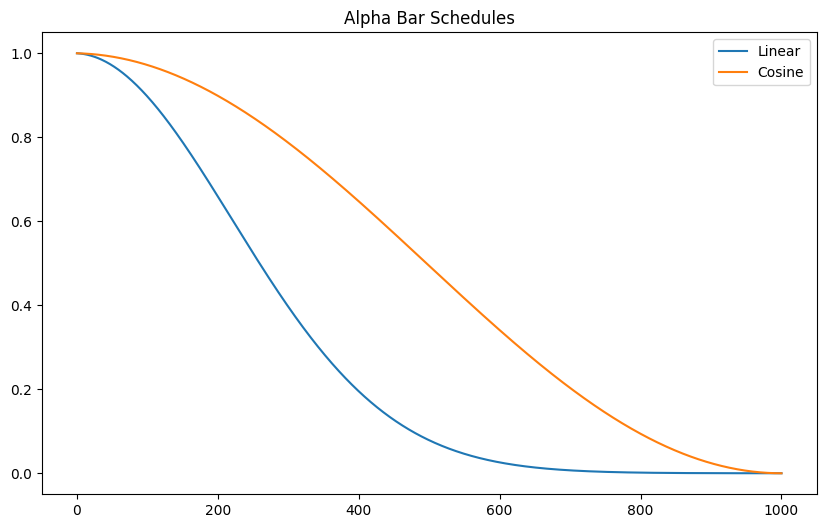

In [7]:
plt.figure(figsize=(10, 6))

plt.title("Alpha Bar Schedules")

plt.plot(alpha_bar_linear, label='Linear')
plt.plot(alpha_bar_cosine, label='Cosine')

plt.legend()

plt.show()

Select which scheduler to use. To prevent broadcasting images, reshape all three lists to (T, 1, 1, 1). Put the tensors on the device, and if you used NumPy to create the tensors, convert from double to floats.

In [8]:
# beta = beta_linear
# alpha = alpha_linear
# alpha_bar = alpha_bar_linear

beta = beta_cosine
alpha = alpha_cosine
alpha_bar = alpha_bar_cosine

beta = beta.view(-1, 1, 1, 1).float().to(device)
alpha = alpha.view(-1, 1, 1, 1).float().to(device)
alpha_bar = alpha_bar.view(-1, 1, 1, 1).float().to(device)

# Part 2: Implement the forward diffusion (training) process

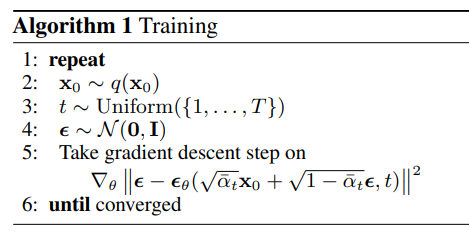

While you might be accustomed to pseudocode, deep learning pseudocode can sometimes be difficult to parse in the beginning and so we will explain all the steps here. The first thing to note is that **there is an implicit batch dimension included in the pseudocode**, so do not interpret this training loop as operating on a single image.

Line 2: Sample a batch of images $x_0$ from you dataset of images $q$. The subscript $0$ denotes the current timestep $t$, i.e. $x_{t=0} \equiv x_0$.

Line 3: Sample from the uniform distribution a batch of timesteps between 1 and $T$. The timesteps in the batch do not need to match.

Line 4: Sample noise from the normal distribution. In line 5 we see that the noise is going to be subtracted and multiplied element-wise to our batch of images. This means that the shape of the noise needs to match the shape of the batch of images, i.e. noise.shape = images.shape = (B, C, H, W).

Line 5: There is an implicit $x_t$ being created here where $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$. Therefore, $x_t$ and $t$ are passed into our diffusion model $\epsilon_{\theta}$. The model's goal is to predict the noise $\epsilon$ that was added into the model. $\lVert \epsilon - \epsilon_{\theta}(x_t, t) \rVert^2$ is our loss and it means to take the mean squared error between $\epsilon$ and our model's prediction of $\epsilon$. The final two parts of line 5 are $\nabla_{\theta}$ and "take the gradient descent step" which translates into pytorch as call `loss.backward()` and `optimizer.step()` respectively.

Lines 1 and 6 mean to continually train your model until there is no improvement.

In [9]:
def training(model, optimizer, dataloader, n_minibatches=1500):
    model.train()  # Let's the model know it is in training mode

    # Implement Algorithm 1 below. You can find what each symbol means in "Denoising Diffusion Probabilistic Models"
    # 1000-2000 minibatches (i.e. optimization steps) is sufficient for learning how to generate images, but more will help make better images
        

    # return training losses

    losses = []

    step = 1
    while step <= n_minibatches:
        for x_0, _ in dataloader:
            x_0 = x_0.to(device)

            t = torch.randint(1, MAX_TIMESTEPS + 1, (x_0.shape[0],)).to(device)

            alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)

            epsilon = torch.randn_like(x_0)

            x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * epsilon
            x_t = x_t.to(device)

            epsilon_theta = model(x_t, t)

            loss = F.mse_loss(epsilon_theta, epsilon)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Step: {step}/{n_minibatches}: {loss.item()}")

            losses.append(loss.item())

            step += 1

            if step > n_minibatches:
                break
            
    return losses

# Part 3: Implement the backward diffusion (sampling) process

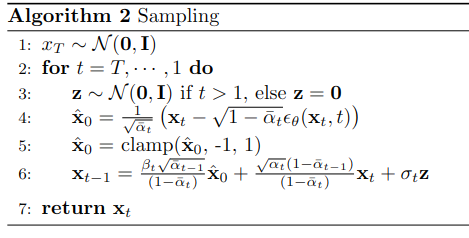

where $\bar{\alpha}_0 = 1$ and $\sigma_t = \sqrt{\beta_t}$.

**Note:** the only time $\alpha_t$ (without bar) is used instead of $\bar{\alpha}_t$ (with bar) is under the square root in the second term on line 6 (the numerator multiplied by $x_t$). If you mix up $\alpha$ and $\bar{\alpha}$, your sampling will not work!

In [10]:
@torch.no_grad()
def sampling(model, batch_size):
    model.eval()  # Let's the model know it is in validation mode

    # Implement Algorithm 2 below. You can find what each symbol means in "Denoising Diffusion Probabilistic Models"

    # return generated image

    x_t = torch.randn(batch_size, 1, IMAGE_SIZE, IMAGE_SIZE).to(device)

    for t in reversed(range(1, MAX_TIMESTEPS + 1)):

        t_tensor = torch.randint(1, MAX_TIMESTEPS + 1, (x_t.shape[0],)).to(device)

        z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)

        epsilon_theta = model(x_t, t_tensor)

        x0_hat = (1 / torch.sqrt(alpha_bar[t])) * (x_t - torch.sqrt(1 - alpha_bar[t]) * epsilon_theta)

        x0_hat = torch.clamp(x0_hat, -1, 1)

        beta_t = beta[t].view(-1, 1, 1, 1)
        alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)
        alpha_bar_t_prev = alpha_bar[t - 1].view(-1, 1, 1, 1) if t > 1 else torch.tensor(1.0, device=device)

        x_t = (beta_t * torch.sqrt(alpha_bar_t_prev) / (1 - alpha_bar_t)) * x0_hat \
            + (torch.sqrt(alpha_bar_t * (1 - alpha_bar_t_prev) / (1 - alpha_bar_t))) * x_t \
            + torch.sqrt(beta_t) * z

    return x_t

# Part 4: Train and generate images

In [11]:
preprocess_transform = Compose([
    Resize(IMAGE_SIZE),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
])

In [12]:
model = UNetModel(
        in_channels=1,
        hidden_channels=32,
        out_channels=1,
        num_res_blocks=2,
        dropout=0.,
        channel_mult=(1, 2, 2, 2),
    ).to(device)

batch_size = 24
dataset = torchvision.datasets.MNIST("data/", train=True, download=True, transform=preprocess_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = AdamW(model.parameters(), lr=LR)

In [13]:
train_losses = training(model, optimizer, dataloader)

Step: 1/1500: 0.9986211061477661
Step: 2/1500: 0.9986470937728882
Step: 3/1500: 0.9835879802703857
Step: 4/1500: 0.9707126021385193
Step: 5/1500: 0.9634000658988953
Step: 6/1500: 0.9775910377502441
Step: 7/1500: 0.9544328451156616
Step: 8/1500: 0.9559521675109863
Step: 9/1500: 0.9544634819030762
Step: 10/1500: 0.9519351720809937
Step: 11/1500: 0.9209381937980652
Step: 12/1500: 0.9278916120529175
Step: 13/1500: 0.9226640462875366
Step: 14/1500: 0.9050053358078003
Step: 15/1500: 0.9022601842880249
Step: 16/1500: 0.9086407423019409
Step: 17/1500: 0.8884226083755493
Step: 18/1500: 0.8739199042320251
Step: 19/1500: 0.8793432116508484
Step: 20/1500: 0.8508455157279968
Step: 21/1500: 0.8427321910858154
Step: 22/1500: 0.8273541331291199
Step: 23/1500: 0.8278965950012207
Step: 24/1500: 0.8258530497550964
Step: 25/1500: 0.824120283126831
Step: 26/1500: 0.8128929138183594
Step: 27/1500: 0.7983673810958862
Step: 28/1500: 0.7859451174736023
Step: 29/1500: 0.7792047262191772
Step: 30/1500: 0.7619413

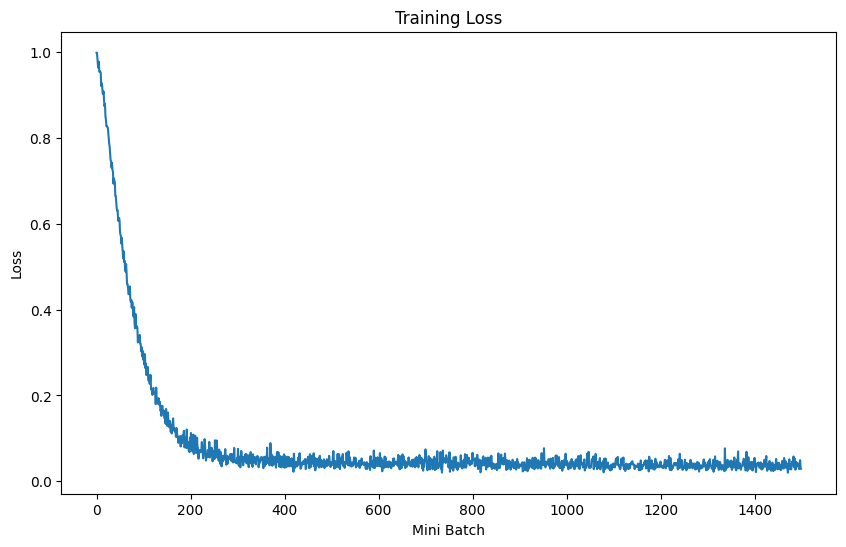

In [14]:
# plot your training loss
plt.figure(figsize=(10, 6))

plt.plot(train_losses)

plt.title("Training Loss")

plt.ylabel("Loss")
plt.xlabel("Mini Batch")

plt.show()

In [15]:
# Use sampling() to generate 16 images and plot them below
images = sampling(model, 16)

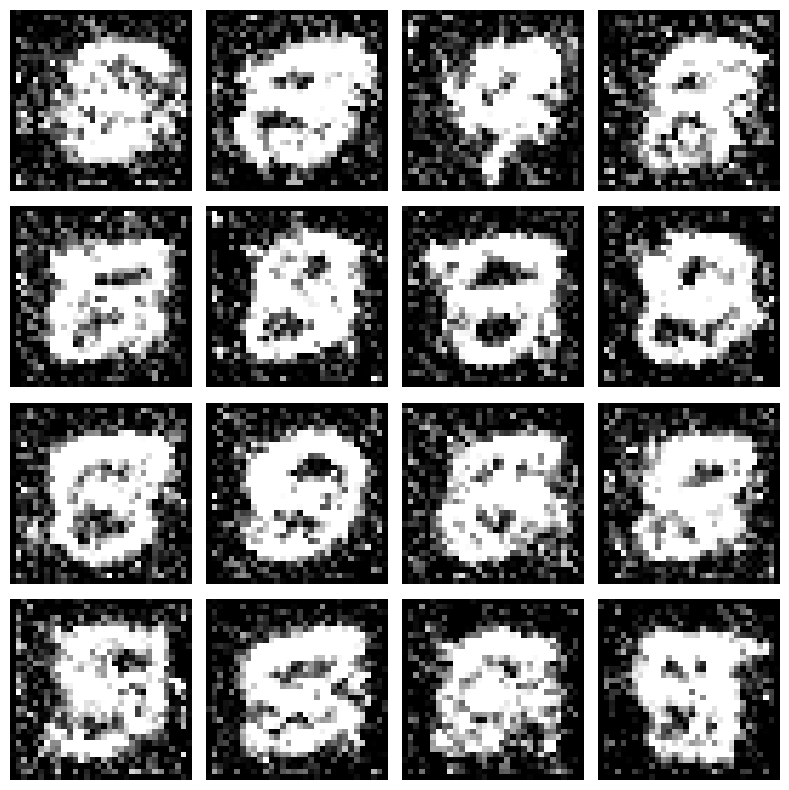

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze().to('cpu'), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Part 5: Questions

1. Where do we scale the values of our training data? What range do we scale the data to? Why do we scale the data in that range?

2. Why is the cosine scheduler better than the linear scheduler?

3. In the forward step, we perform a random number of denoising steps in one forward pass, but in the backward process, we have to perform T forward passes to generate images. Why is that?

4. What is our network learning to predict?

5. If we wanted to perform conditional generation; for example, if we wanted to provide our network with a digit and have it produce an image of that digit, what would we have to change?

1. We generally scale the values of the training data before feeding them into our model (the preproccessing step). We scales the values to between [0, 1] or [-1, 1] depending on the activation function. Scaling in this way ensures that the data is centered and has a similar magnitude.

2. The cosine scheduler is better than the linear scheduler because it allows for more agressive exploration in the beginning of the training stage, and more conservative explorationg later on.

3. In the forward step a random number of timesteps is used to model noise at different levels of corruption. In the backward process, T steps are used to remove a small amount of noise with each step.

4. The network is learning to predict the noise added at each timestep. More specifically, the model predicts the noise that was added at each of the T timesteps based on the noisy image at the current timestep.

5. You would modify the network to take in a conditional input along with the noisy image at each timestep. We could do this by concatenating the condition with the image at each timestep, either as a one-hot encoded vector or an embedding of the digit.